# Recalculating Accretion Rates:

### 1. Accretion luminosity:
    
*Variables needed:*
        
1. name of emission line
    
2. emission line flux
    
3. object distance

4. extinction (for some)

5. equivalent width (for some)

6. band magnitude (for some)

*Procedure:*

1. Turn EW into line flux using the band magnitude (already done in the database. Written here for completion).

2. Correct line flux for extinction if it is not already corrected (note: need a list of which are/aren't).

3. Turn line flux into line luminosity using distance estimate, or existing line luminosity into an updated one using updated distance estimate

4. Turn line luminosity into accretion luminosity using scaling relations from Alcala (2017).

### 2. Accretion rate:

*Variables needed:*

1. accretion luminosity

2. object mass (from spectral type to temperature to evolutionary tracks)

3. object radius (from evolutionary tracks as well)

4. magnetospheric radius (assumed to be 5 \* object radius)

In [1]:
from numpy import *
import astropy.units as u
from astropy.constants import G, M_jup, R_jup, M_earth, R_earth, L_sun, M_sun, R_sun
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import extinction as ex

In [2]:
#import scaling relation coefficients
rel = pd.read_csv('scalingrels_a17.csv')
rel.set_index('Tracer', inplace=True)

In [3]:
def line_lum_distconv(line_lum_old, dist_old, dist_new):
    """
    Calculate the line luminosity at a distance
    given the line luminosity at another distance.
    
    """
    line_lum_new = line_lum_old * (dist_old**2)/(dist_new**2)
    return line_lum_new

def line_lum(line_flux, dist):
    """
    Calculate line luminosity given line flux and distance
    assuming line flux is extinction corrected.
    """
    #future: could add extinction correction in there? Not sure how that works.
    
    line_lum = 4 * pi * (dist*u.pc)**2 * line_flux * u.erg / (u.s * (u.cm)**2)
    line_lum = line_lum.decompose().to(u.W)
    return line_lum/u.W

def l_to_f(lum,dist,lsun_units=False):
    """
    Converts a line luminosity into line flux in erg/s/cm^2.
    Specify whether luminosity is in units of L_sun. Default is False
    (in W (but actually dimensionless)).
    
    """
    f = lum*u.W/(4 * pi * (dist*u.pc)**2)
    f = f.decompose().to(u.erg / (u.s * (u.cm)**2))
    if lsun_units == True:
        f*=L_sun/u.W
    return f/(u.erg / (u.s * (u.cm)**2))

def get_dist(L, F):
    """
    Get distance in pc given luminosity and flux, in W and erg/s/cm^2, respectively
    """
    d = (L*u.W / (F*(u.erg/(u.s*(u.cm)**2))*4*pi))**0.5
    d = d.decompose().to(u.pc)
    return d/u.pc

In [4]:
def accr_lum(L_line, tracer, L_line_err = 0*u.W):
    """
    Translate a line luminosity to accretion luminosity using empirical
    relationships from Alcala et al. 2017.
    
    Included tracers are:
    'Ha'
    'Hb'
    'Hg'
    'PaB'
    'PaG'
    'He I 587.6'
    'He I 667.8'
    'Ca II K'
    'Ca II H'
    """
        
    a, a_err, b, b_err = rel['a'][tracer],rel['a_err'][tracer],rel['b'][tracer],rel['b_err'][tracer]
    
    log_L_acc = b + a * log10(L_line*u.W/L_sun)
    
    L_acc = 10**log_L_acc*L_sun/u.W
    
    #attempt at error propagation
    
    #c_err = (L_line_err)/(log(10) * L_line)
    #ac_err = a * log10(L_line/L_sun) * ((a_err/a)**2 + (c_err/log10(L_line/L_sun))**2)**0.5
    #log_L_acc_err = (b_err**2 + ac_err**2)**0.5
    #L_acc_err = L_acc * log(10) * log_L_acc_err

    return L_acc

***Error propagation:*** *this is how I **think** the error propagation should work for the scaling relation. Need to check this.*

Overall formula: $\log (L_{acc}/L_{\odot}) = a \cdot \log(L_{line}/L_{\odot}) + b$

Errors:

$\delta c = \delta \log(L_{line}/L_{\odot}) = \frac{1}{\ln10} \frac{\delta L_{line}}{L_{line}}$

$\delta ac = ac \cdot \sqrt{(\frac{\delta a}{a})^2 + (\frac{\delta c}{c})^2}$

$\delta \log(L_{acc}) = \delta (ac + b)= \sqrt{(\delta ac)^2 + (\delta b)^2}$

In [5]:
def acc_rate(L_acc, R, M):
    """
    Translate an accretion luminosity and planet mass/radius to accretion rate in Solar masses per year.
    """
    mdot = 1.25*L_acc*u.W*R*u.R_sun/(G*M*u.M_sun)
    mdot = mdot.decompose().to(u.M_sun/u.yr)
    return(mdot/(u.M_sun/u.yr))

In [6]:
def get_rate(line_flux, d, t, R, M):
    """
    Turn a line flux into an accretion rate, 
    given the distance, tracer, object radius, and object mass.
    """
    l_line = line_lum(line_flux,d)
    l_acc = accr_lum(l_line, t)
    mdot = acc_rate(l_acc, R, M)
    
    return mdot

# Cells above: functions for conversions and calculations

# Cells below: tests with the database

***1. Import database. Keep only relevant columns, which are:***

**Source, Mass, Radius, Distance, Line Flux (each tracer)**

*Additional considerations:*

1. Do I want to import age and disk type etc, too? Probably, as we will want to use them to narrow down the physical causes of scatter in the relation.

2. Do I want a flag for line flux from EW? Not sure.

3. Do I want to have empty columns for L_line for each tracer? Or create them as I go?

4. It really would be easier to do this if I had a row for each instance of each source, rather than columns for each tracer. Then I could simply take acc_lum(db['tracer'][i], db['Line Lum'][i]) once for each row. Is there a way I can easily make the database into that style now? I don't think so.

***2. Convert every line flux to a line luminosity***

***3. Convert every line luminosity to an accretion luminosity***

***4. Convert every accretion luminosity into an accretion rate***

**Additional considerations:**

This procedure does *not* account for 1. The papers that only report EW. 2. The papers that report L but not flux. 3. The other ones that do none of these things. Can do these by:

1. Getting flux *from* EW using either R band magnitude or a complex spectral type fitting method.

2. Turning L_line into new L_line using distance conversion. To do so, need the old distance estimate (ex Natta 2006 only reports L(Pa$\beta$).

3. ???


# Part 2:       

## Test 4: Figure out distance used in N06

They don't report distance. Manara 2015 says they used 160 pc, while the newest estimates are of 125 pc.

I've converted the reported EWs into line fluxes using the SIMBAD J-band magnitude. Theoretically, if I correct for extinction using either $A_V$ or $A_J$, when I run the fluxes and luminosities through the get_dist function, I should get them all around 160 pc. I do not. This is confusing. Will stop worrying about it for now, though.

In [66]:
db = pd.read_csv('recalculations.csv')
tracers = ['Ha','Hb','Hg','PaB','PaG','BrG','He I 587.6','He I 667.8','Ca II K','Ca II H']

In [67]:
n6 = db.loc[db['Reference']=='Natta 2006']

In [68]:
aj = n6.loc[:,'A_J'].tolist()
pab = n6.loc[:,'PaB Line Flux'].tolist()
cf = [ex.remove(aj[i],pab[i]) for i in arange(len(aj))]
n6.loc[:,'cf']=cf

In [69]:
di2 = []
for i in n6.index:
    d2=float(get_dist(n6.loc[i,'PaB Line Luminosity']*L_sun/u.W,n6.loc[i,'cf']))
    di2.append(d2)

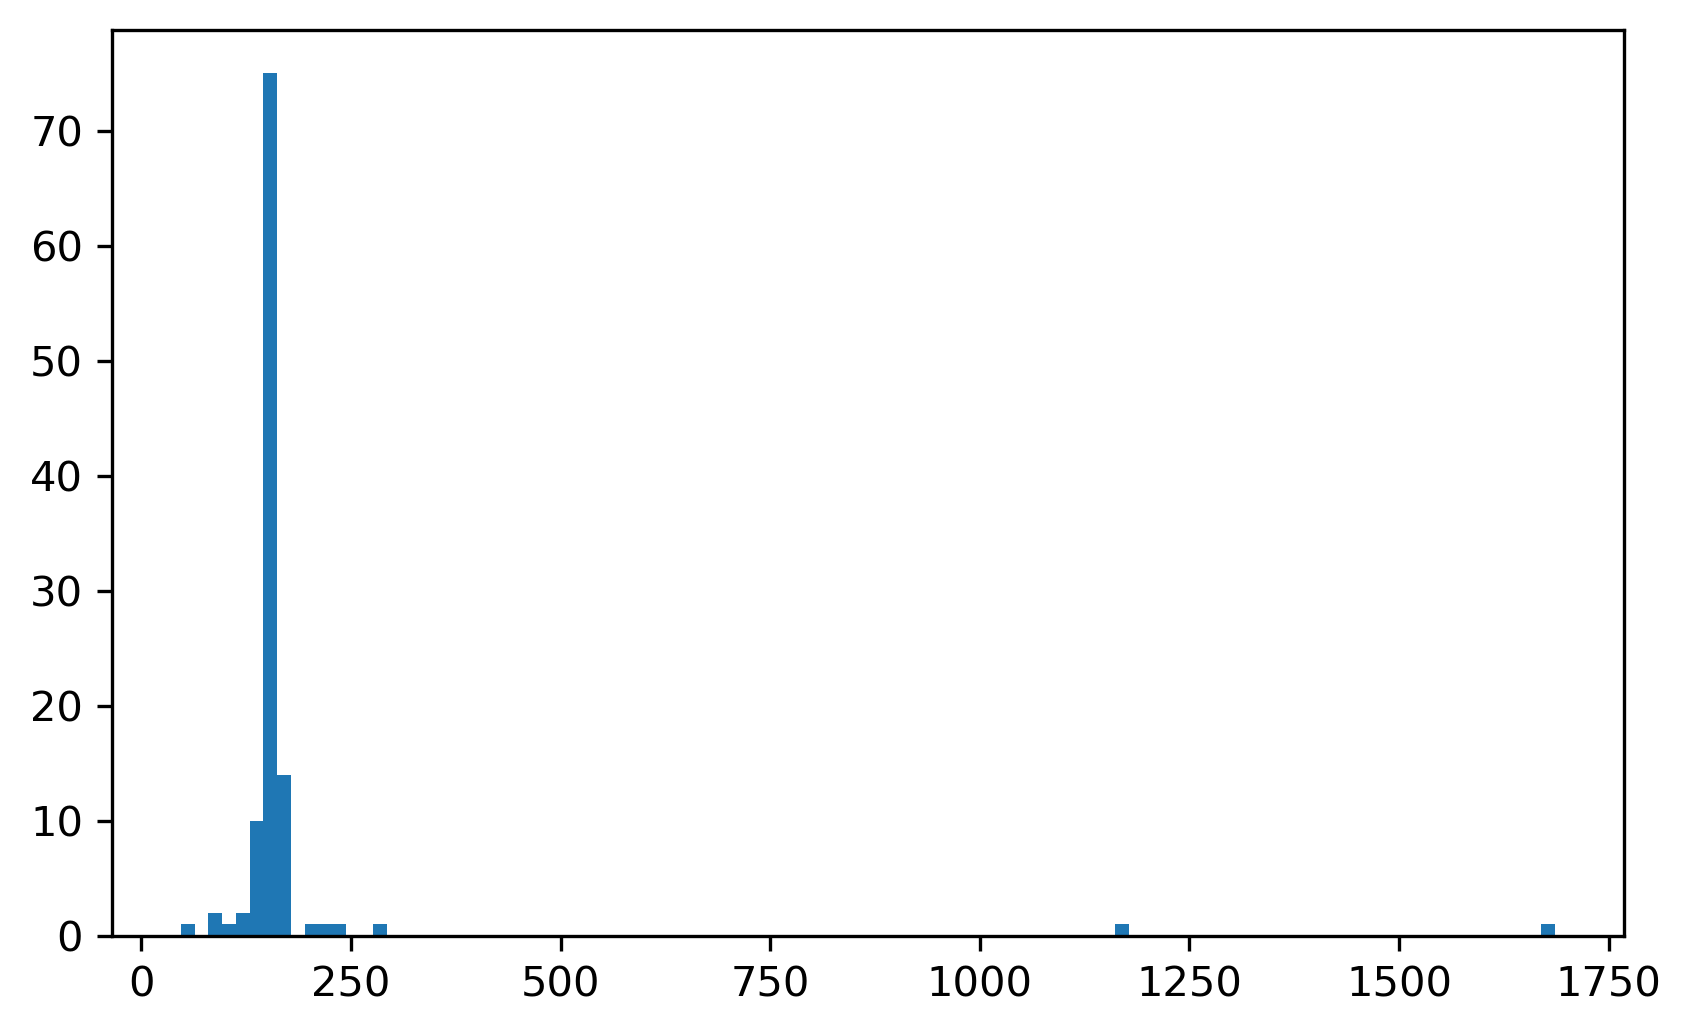

In [45]:
plt.figure(figsize=(6.5,4),dpi=300)
dd = plt.hist(di2,bins=100)

## Test 3: Recalculate all accretion rates using Alcala (2017) relations

In [58]:
db = pd.read_csv('recalculations.csv')
tracers = ['Ha','Hb','Hg','PaB','PaG','BrG','He I 587.6','He I 667.8','Ca II K','Ca II H']

In [59]:
#Natta 06 PaB line lum is in L_solar instead of W.
#So converting that here since all the others are in W
for i in db.index:
    if db.loc[i,'Reference']=='Natta 2006':
        db.at[i,'PaB Line Luminosity'] *=L_sun/u.W

In [60]:
#for all objects in the recalculations sheet, calculate an accretion rate
#for whatever tracers are available

for i in db.index:
    d = db.loc[i,'Object Distance']
    R = db.loc[i,'Object Radius']
    M = db.loc[i,'Object Mass, Original']
    if (isnan(M) or isnan(R)):
        continue
    for t in tracers:
        lf = db.loc[i,t + ' Line Flux']
        if isnan(lf)==False:
            db.at[i,t + ' Accr Rate'] = get_rate(lf, d, t, R, M)

In [61]:
#special stuff for our friends natta '06
for i in db.loc[db['Reference']=='Natta 2006'].index:
    ll = db.loc[i,'PaB Line Luminosity']
    R = db.loc[i,'Object Radius']
    M = db.loc[i,'Object Mass, Original']
    if isnan(ll)==False:
        la = accr_lum(ll, 'PaB')
        db.at[i,'PaB Accr Rate'] = acc_rate(la, R, M)

In [62]:
#take average accretion rate
db['Avg Accr Rate'] = db[[t + ' Accr Rate' for t in tracers]].mean(axis=1)

In [63]:
aa = db[['Source','Reference','Object Mass, Original', 'Avg Accr Rate','Old Accr Rate']].dropna()

In [64]:
m = log10(aa['Object Mass, Original'].tolist())
md_old = log10(aa['Old Accr Rate'].tolist())
md_new = log10(aa['Avg Accr Rate'].tolist())

Text(0, 0.5, 'log $\\dot M$  $(M_{\\odot}/yr)$')

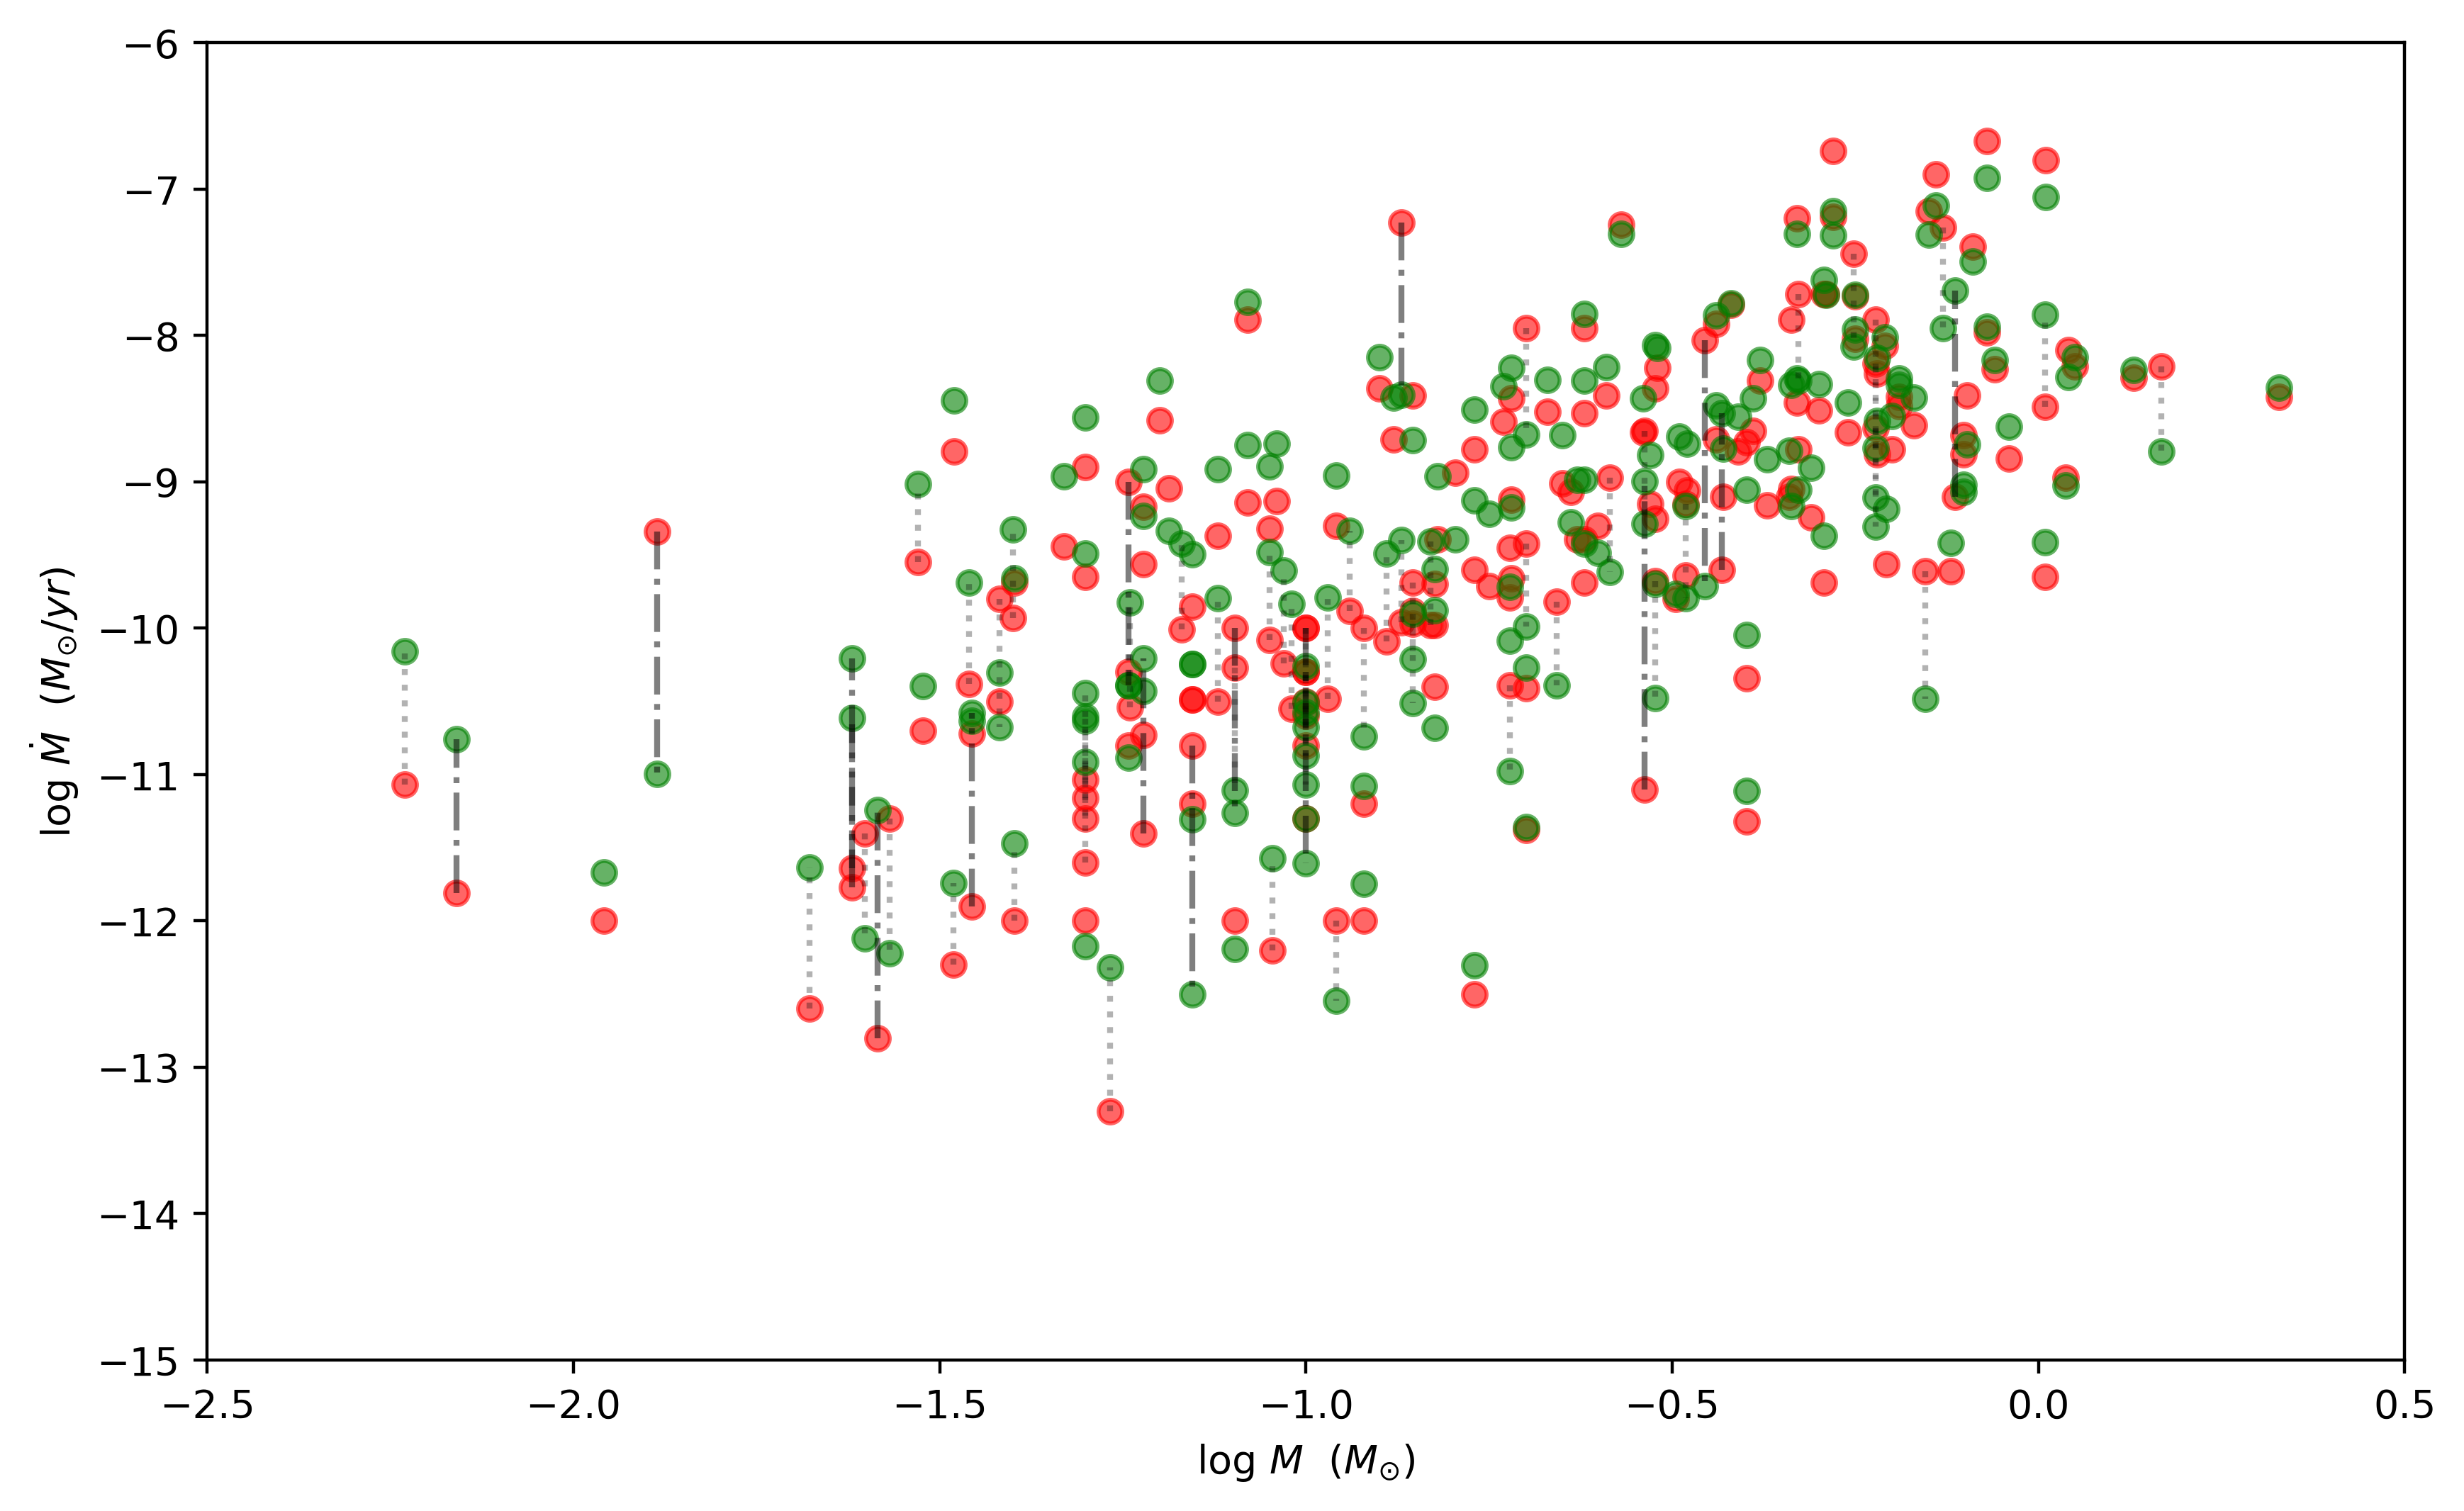

In [65]:
#plot M vs Mdot for both old and new accr rates

plt.figure(figsize=(10,10/1.625),dpi=400)

plt.scatter(m,md_old,color='r',alpha=0.6)
plt.scatter(m,md_new,color='g',alpha=0.6)

#connect highly discrepant points with lines
for i in range(len(md_old)):
    if abs(md_old[i]-md_new[i])>1:
        plt.plot([m[i],m[i]],[md_old[i],md_new[i]],color='k',linestyle='-.',alpha=0.5)
    elif abs(md_old[i]-md_new[i])>0.5:
        plt.plot([m[i],m[i]],[md_old[i],md_new[i]],color='k',linestyle='dotted',alpha=0.3)

plt.ylim(-15,-6)
plt.xlim(-2.5,0.5)
plt.xlabel('log $M$  $(M_{\odot})$')
plt.ylabel('log $\dot M$  $(M_{\odot}/yr)$')

## Test 2: Reproduce Manara 2015

They use an average of several emission lines with scaling relations from Alcala (2014). I was going to reproduce Herczeg 2009, but that ended up being more complicated than I wanted it to be. Not that this is particularly simple.

In [ ]:
rels2 = pd.read_csv('scalingrels_a14.csv')
rels2.set_index('Tracer', inplace=True)
db = pd.read_csv('recalculations.csv')
tracers = ['Ha','Hb','Hg','PaB','PaG','BrG','He I 587.6','He I 667.8','Ca II K','Ca II H']

In [ ]:
M15 = db[db['Reference']=='Manara 2015']
#changing 2 names so they're consistent with the M15 paper (changed to 2mass in db)
M15.at[29,'Source'] = 'ISO-Oph 164'
M15.at[30,'Source'] = 'ISO-Oph 176'
M15 = M15.sort_values(by='Source')

#create table that looks like the table in M15 so it's easy to compare

name = M15['Source'].tolist()
L_acc = zeros(17)
M_acc = zeros(17)
Detected_Lines = zeros(17)
res = {'Name':name,'L_acc':L_acc,'M_acc':M_acc,'Detected_Lines':Detected_Lines}
results = pd.DataFrame(res,columns=['Name','L_acc','M_acc','Detected_Lines'])

In [ ]:
def m15_Lacc(i):
    """
    Calculates mean accretion luminosity and number of tracers used to compute L_acc
    for sources in Manara 2015. Must input an index (this is very specific to the exact
    version of the database we have).
    """
    la = []
    for t in tracers:
        a,b = rels2['a'][t],rels2['b'][t]
        lf = M15[t + ' Line Flux'][i]
        if isnan(lf)==False:
            L_line = line_lum(lf, 125)
            log_L_acc = b + a * log10(L_line*u.W/L_sun)
            la.append(log_L_acc)
    
    return (mean(la),len(la))

In [ ]:
#calculate mean L_acc and M_acc and make into a table like in M15
L_acc = []
M_acc = []
Num_Lines = []
for i in M15.index:
    lacc = m15_Lacc(i)
    L_acc.append(round(float(lacc[0]),2))
    Num_Lines.append(lacc[1])
    rate = log10(acc_rate(L_sun * 10**lacc[0] / u.W,M15['Object Radius'][i],M15['Object Mass, Original'][i]))
    M_acc.append(round(float(rate),2))

res = {'Name':name,'L_acc':L_acc,'M_acc':M_acc,'Num_Lines':Num_Lines}
results = pd.DataFrame(res,columns=['Name','L_acc','M_acc','Num_Lines'])
results

### Test 1: Natta 2006: compare old vs new $L_{acc}$

Given Pa$\beta$ luminosity, convert to accretion luminosity

In [ ]:
db = pd.read_csv('accdb_master_copy.csv')

natta06 = db[db['Reference']=='Natta 2006']
n06 = natta06[['Source', 'Object Mass M_Solar','Object Radius from L and T','PaB Line Lum (L_solar)','Log Accretion Luminosity (solar)']]
n06 = n06.dropna()

In [ ]:
l_line = [float(i) for i in n06['PaB Line Lum (L_solar)'].tolist()]
log_l_acc_orig = [float(i) for i in n06['Log Accretion Luminosity (solar)'].tolist()]
l_acc = []
for i in l_line:
    l_acc.append(accr_lum(i,'PaB'))
log_l_acc = log10(l_acc)

In [ ]:
m = [float(i) for i in n06['Object Mass M_Solar'].tolist()]
r = [float(i) for i in n06['Object Radius from L and T'].tolist()]
acc = [acc_rate(l_acc[i],r[i],m[i]) for i in range(len(l_acc))]

In [ ]:
polyfit(log_l_acc_orig, log_l_acc,1)

In [ ]:
plt.figure(figsize = (6.5,4), dpi = 250)
plt.scatter(log_l_acc_orig, log_l_acc,label='y=0.78x-0.36 \nr=0.999')
labx = plt.xlabel('$L_{acc}$ (N06)')
laby = plt.ylabel('$L_{acc}$ (A17)')
x = arange(-6.3,0.5,.1)
plt.plot(x,x, color = 'r',label = 'y=x')
plt.legend(frameon=False)